Image shape: (162, 1412, 1412, 4)
Mask shape: (162, 1412, 1412)


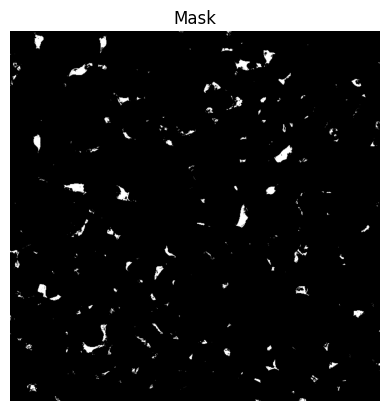

In [1]:

from tifffile import imread, imwrite
from pathlib import Path
import napari
import numpy as np
from skimage.io import imread
import napari
import matplotlib.pyplot as plt
# Load image and mask
image_path = "Series003_cCAR_tumor.tif"
mask_path = "masked_predictions.tiff"
image = imread(image_path)  # Expecting shape: (H, W, C)
mask = imread(mask_path)    # Expecting shape: (H, W)
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

# Create Napari viewer
viewer = napari.Viewer()

# Add the binary mask
viewer.add_image(mask, name='Mask', colormap='grey', blending='additive', opacity=0.5)

# Apply mask to each channel
masked_image = image * mask[..., np.newaxis]  # shape: (H, W, C)

# Split and add each channel separately
colormaps = ['gray', 'green', 'blue', 'magenta']
channel_names = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']
for i in range(masked_image.shape[-1]):
    viewer.add_image(
        masked_image[..., i],
        name=channel_names[i],
        colormap=colormaps[i],
        blending='additive',
        opacity=0.75
    )

napari.run()
# Normalize mask to be between 0 and 255

plt.imshow((mask * 255).astype(np.uint8)[55], cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()


### Smoothing and spliting of cells
We obtain a mask that doesn't necessarly posses a cell shape. And we potentially need to split those connected pixels between multiple cells. For that we want to use voronoi_otsu_labeling in order to smooth the mask which will generate elipse (cell shape) and split the connected pixels of the mask between diffrent cells.

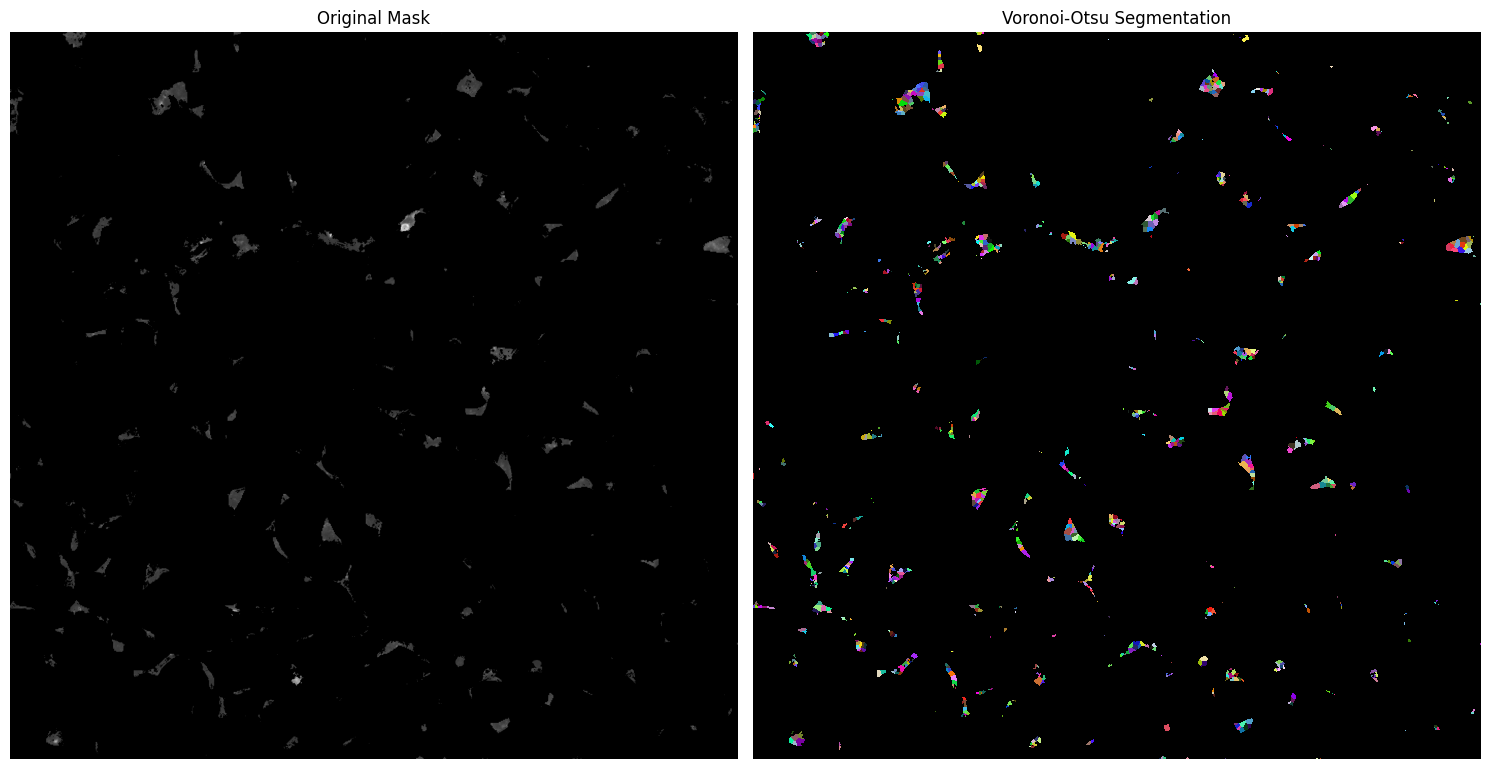

In [9]:
# Add new cell with imports
import pyclesperanto_prototype as cle
from skimage.transform import resize
import matplotlib.pyplot as plt

# Initialize GPU (add this in a new cell)

# Add processing cell
def process_tcell_mask(mask_data, spot_sigma=1, outline_sigma=1):
    """Process T-cell mask using Voronoi-Otsu labeling"""
    # Push mask to GPU
    mask_gpu = cle.push(mask_data)
    
    # Apply Voronoi-Otsu labeling
    segmented = cle.voronoi_otsu_labeling(mask_gpu, 
                                         spot_sigma=spot_sigma, 
                                         outline_sigma=outline_sigma)
    
    return segmented

# Add visualization cell
def visualize_segmentation(original_mask, segmented_mask):
    """Visualize original and segmented masks"""
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    
    # Original mask
    axs[0].imshow(original_mask, cmap='gray')
    axs[0].set_title('Original Mask')
    axs[0].axis('off')
    
    # Segmented result
    cle.imshow(segmented_mask, labels=True, plot=axs[1])

    axs[1].set_title('Voronoi-Otsu Segmentation')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Add processing execution cell
# Use your existing mask data

# Process each frame if it's a time series
masked_image_one_chanel = masked_image[..., 0]
if len(masked_image_one_chanel.shape) > 2:
    # Process first frame as example
    segmented = process_tcell_mask(masked_image_one_chanel[42])
    visualize_segmentation(masked_image_one_chanel[42], segmented)
else:
    # Process single frame
    segmented = process_tcell_mask(masked_image_one_chanel)
    visualize_segmentation(masked_image_one_chanel, segmented)

That's better. However, we need to adjust two parameters correctly: `spot_sigma` and `outline_sigma`.

- **`spot_sigma`** controls the number of cells detected within a continuous marked pixel zone.  
  Increasing `spot_sigma` results in fewer detected cells, as the algorithm merges more neighboring pixels into a single cell.

- **`outline_sigma`** affects the smoothing of the image.  
  A higher `outline_sigma` value produces smoother shapes and outlines by applying more aggressive image smoothing.


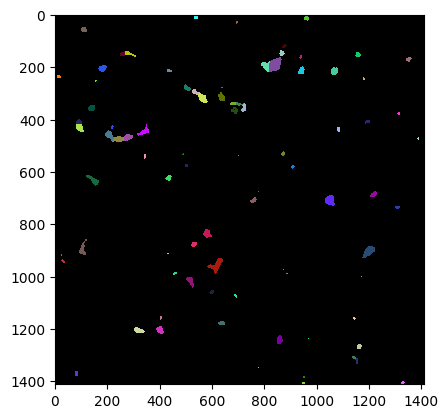

In [10]:
# Test different parameters
spot_sigmas = [6]
outline_sigmas = [4]

for spot_sig in spot_sigmas:
    for outline_sig in outline_sigmas:
        segmented = process_tcell_mask(masked_image_one_chanel[88],
                                     spot_sigma=spot_sig,
                                     outline_sigma=outline_sig)

        # Segmented result
        cle.imshow(segmented, labels=True)
        plt.show()
            

In [15]:
# Test different parameters
spot_sigmas = [6]
outline_sigmas = [2]
for i in range(masked_image_one_chanel.shape[0]):
    for spot_sig in spot_sigmas:
        for outline_sig in outline_sigmas:
            segmented = process_tcell_mask(masked_image_one_chanel[i],
                                         spot_sigma=spot_sig,
                                         outline_sigma=outline_sig)



The post processing is done!!

In [16]:
import matplotlib.colors as mcolors

def generate_unique_colors(segmented_data, background_value=0):
    """Generate unique colors for each unique value in the segmented data."""
    unique_values = np.unique(segmented_data)
    unique_values = unique_values[unique_values != background_value]  # Exclude background value

    color_map = {}
    for value in unique_values:
        # Hash the value to generate a unique color
        np.random.seed(value)  # Use the value as the seed for reproducibility
        color = np.random.rand(3)  # Generate random RGB values
        color_map[value] = mcolors.to_hex(color)  # Convert to hex color

    return color_map

# Generate unique colors for the segmented data
segmented_values = segmented.get()  # Assuming `segmented` is a GPU array, fetch it to CPU
color_map = generate_unique_colors(segmented_values)

# Display the color map
for value, color in color_map.items():
    print(f"Value: {value}, Color: {color}")

Value: 1, Color: #6ab800
Value: 2, Color: #6f078c
Value: 3, Color: #8cb54a
Value: 4, Color: #f78cf8
Value: 5, Color: #39de35
Value: 6, Color: #e455d1
Value: 7, Color: #13c770
Value: 8, Color: #dff7de
Value: 9, Color: #03807e
Value: 10, Color: #c505a2
Value: 11, Color: #2e0576
Value: 12, Color: #27bd43
Value: 13, Color: #c63dd2
Value: 14, Color: #83c5de
Value: 15, Color: #d82e0e
Value: 16, Color: #39858c
Value: 17, Color: #4b8731
Value: 18, Color: #a681e0
Value: 19, Color: #19c23f
Value: 20, Color: #96e5e3
Value: 21, Color: #0c4ab8
Value: 22, Color: #357b6b
Value: 23, Color: #84f1c3
Value: 24, Color: #f5b2ff
Value: 25, Color: #de9447
Value: 26, Color: #4f84c4
Value: 27, Color: #6dd0bc
Value: 28, Color: #ba8f20
Value: 29, Color: #dc4913
Value: 30, Color: #a461a9
Value: 31, Color: #49f4c4
Value: 32, Color: #db5f8e
Value: 33, Color: #3f7369
Value: 34, Color: #0ac718
Value: 35, Color: #754f3b
Value: 36, Color: #ba99f3
Value: 37, Color: #f17631
Value: 38, Color: #62dbf1
Value: 39, Color: #8b

In [17]:
from tqdm import tqdm

def apply_color_map_vectorized(segmented_values, color_map):
    """Apply color map in a vectorized way."""
    # Ensure the color map keys are integers
    keys = np.array(list(color_map.keys()), dtype=int)

    # Convert hex to RGB [0, 1]
    colormap_array = np.array([mcolors.to_rgb(color_map[k]) for k in keys], dtype=np.float32)

    # Build a lookup table
    max_label = segmented_values.max()
    lut = np.zeros((max_label + 1, 3), dtype=np.float32)
    lut[keys] = colormap_array

    # Apply the color map using LUT
    rgb_image = lut[segmented_values]

    return rgb_image

# Apply the color map
colored_segmented_image = apply_color_map_vectorized(segmented_values, color_map)

In [18]:
# Test different parameters
from turtle import color

viewer = napari.Viewer()

for spot_sig in spot_sigmas:
    for outline_sig in outline_sigmas:
        # Add original image to Napari
        viewer.add_image(
            masked_image_one_chanel,
            name='Masked Image',
            colormap='gray',
            blending='additive',
            opacity=1
        )

        # Add unmasked image with enhanced contrast to Napari
        colormaps = ['magenta', 'blue', 'green', 'red']  # Diverse colormaps
        for i in range(image.shape[-1]):
            viewer.add_image(
                image[..., i],
                name=f'Channel {i+1}',
                colormap=colormaps[i],
                blending='additive',
                opacity=0.7
            )

        # Add segmented image to Napari with normalized values
        segmented_normalized = (segmented.astype(float) - segmented.min()) / (segmented.max() - segmented.min())
        viewer.add_image(
            colored_segmented_image,
            name='Segmented Image',
            colormap='viridis',  # Using viridis for better distinction
            blending='additive',
            opacity=0.8
        )

napari.run()